The question is how well the Balmer-decrement-derived mean extinction, can correct line-flux ratios at other wavelength combinations; after discussion with LVM team

In [1]:
import numpy as np
import matplotlib
from astropy.io import fits as fits
from astropy.table import Table
from matplotlib.colors import LogNorm
import scipy.stats as stats

# Set up matplotlib
import matplotlib.pyplot as plt

#reddening curves KK
from dust_extinction.parameter_averages import CCM89, F99
import astropy.units as u

In [2]:
#define a few extinction-related quanbtities (REF)
def kl(lam):   # get the extinction at wavelength lambda [in microns], to be multiplied by E(B-V)
    if (lam <0.6):
        return -5.726 + 4.004/lam - 0.525/lam**2 +0.029/lam**3 + 2.505
    else:
        return -2.672 -  0.010/lam + 1.532/lam**2  - 0.412/lam**3 +2.505

In [3]:
#define a few extinction-related quanbtities (REF) ##KK edited
def k_dust(lam):   # get the extinction at wavelength lambda [in microns], to be multiplied by E(B-V)
    lam2=(lam*u.micron)
    #ext_model = CCM89(Rv=3.1)
    #ext_model = F99(Rv=3.1)
    #return ext_model(lam2)
    return F99.evaluate(F99,lam2,Rv=3.1)*3.1
    #return CCM89.evaluate(lam2,3.1)*3.1

In [47]:
print(kl(0.3727), kl(0.4868), kl(0.5007), kl(0.6564))   # just testing

4.302841399454492 3.0401021341509247 2.912700470713361 1.9166650939965764


In [48]:
print(k_dust(0.3727), k_dust(0.4868), k_dust(0.5007), k_dust(0.6564))   # just testing KK

[4.66682226] [3.60855013] [3.47029817] [2.356559]


#### Now define  the true change in the line ratio (at $\lambda_1$ vs $\lambda_2$), caused by patchy dust-extinction with E(B-V), except for a clear (area) fraction of $\epsilon$. And define the estimated E(B-V) from the observed Balmer decrement (or any other line ratio, assuming homogeneity)

In [13]:
def line_ratio_reddening(lam1,lam2,EBV,eps):
    exp_alam1 = np.exp(-k_dust(lam1)*EBV) #KK
    exp_alam2 = np.exp(-k_dust(lam2)*EBV) #KK
    return (eps*(1-exp_alam1)+exp_alam1) / (eps*(1-exp_alam2)+exp_alam2)

def estimate_EBV(lam1,lam2,line_ratio_change):  # "line_ratio_change" is the ratio by 
    #which the observed line ratio differs from the expected (unreddened) one; e.g. 2.86 for the Balmer decrement
    if (line_ratio_change>1.):
        print('wrong line ratio regime')
    else:
        return -np.log((line_ratio_change))/(k_dust(lam1)-k_dust(lam2)) #KK dust
    
def sys_err(lam1,lam2,EBV,eps):  #  systematic error in dereddening line ratios at lam1 and lam2,
                                 #  using the Balmer decrement, when E(B-V) and epsilon
    BD_obs = line_ratio_reddening(0.4868,0.6564,EBV,eps) # true amount by which the Balmer decretent is altered
    EBV_estimated = estimate_EBV(0.4868,0.6564,BD_obs)  # actually estimated B.d. to be from the observed line ratios
    line_ratio_obs = line_ratio_reddening(lam1,lam2,EBV,eps)
    line_ratio_after_inferred_correction = line_ratio_reddening(lam1,lam2,EBV_estimated,0.)
    return line_ratio_obs/line_ratio_after_inferred_correction


def sys_err_array(lam1,lam2,X,Y):   # get the previous function for a 2D array
    Z = 0*X
    for i in range(len(X[0,:])):
        for j in range(len(Y[:,0])):
            Z[i,j] = np.log10( np.abs( sys_err(lam1,lam2,X[i,j],Y[i,j]) ) ) #log to log10
    return Z
  

Now assume there is a certain foreground absorption of E(B-V), that covers all but $\epsilon$ of the spaxel (where the flux emerges unattenuated).
Let's make a 2D plot of the systematic error incurred when using the Balmer decrement to de-reddene [OII]/[OIII], as a function of E(B-V) and $\epsilon$

In [12]:
x = np.linspace(0.05, 1.1, 50)
y = np.linspace(0.01, 0.3, 50)

X, Y = np.meshgrid(x, y)
Z = sys_err_array(0.3727,0.5007,X,Y)  # this is specific to 3727 / 5007

#plt.contourf(X, Y, Z, 20, cmap='RdGy');
#plt.contourf(X, Y, Z, 20, cmap='nipy_spectral'); #orig
plt.contourf(X, Y, Z, 20, cmap='nipy_spectral',vmin=0,vmax=0.2); #KK
#plt.colorbar();
plt.xlabel('E(B-V)',fontsize=18,labelpad=0)
plt.tick_params(labelsize=14)
plt.ylabel('$\epsilon_{unobscured}$',fontsize=18,labelpad=0)
cbar = plt.colorbar()
cbar.set_label('log(sys. [OII]/[OIII] error)', rotation=270,fontsize=16,labelpad=23)
plt.savefig('systematic_dereddening_error_F99.pdf')

KeyboardInterrupt: 

In [35]:
x[26]

0.6071428571428572

In [38]:
tmparr=Z[:,26]
print(tmparr)
np.median(tmparr)

[0.01545847 0.02237865 0.02804622 0.03269961 0.03652403 0.03966527
 0.04223945 0.04433998 0.04604273 0.04740979 0.04849236 0.04933295
 0.04996706 0.0504245  0.05073042 0.05090615 0.05096984 0.05093701
 0.05082095 0.05063313 0.0503834  0.05008033 0.04973132 0.04934283
 0.04892047 0.04846914 0.04799314 0.04749622 0.04698167 0.04645238
 0.04591091 0.04535948 0.04480006 0.0442344  0.04366402 0.04309027
 0.04251434 0.04193728 0.04136    0.04078333 0.04020797 0.03963456
 0.03906365 0.03849572 0.03793119 0.03737043 0.03681377 0.03626146
 0.03571377 0.03517088]


0.04457002369620801

The following uses HWs original code:

In [8]:
##original from HW
def line_ratio_reddening_orig(lam1,lam2,EBV,eps):
    exp_alam1 = np.exp(-kl(lam1)*EBV) 
    exp_alam2 = np.exp(-kl(lam2)*EBV) 
    return (eps*(1-exp_alam1)+exp_alam1) / (eps*(1-exp_alam2)+exp_alam2)

def estimate_EBV_orig(lam1,lam2,line_ratio_change):  # "line_ratio_change" is the ratio by 
    #which the observed line ratio differs from the expected (unreddened) one; e.g. 3.86 for the Balmer decrement
    if (line_ratio_change>1.):
        print('wrong line ration regime')
    else:
        return -np.log(line_ratio_change)/(kl(lam1)-kl(lam2))
    
def sys_err_orig(lam1,lam2,EBV,eps):  #  systematic error in dereddening line ratios at lam1 and lam2,
                                 #  using the Balmer decrement, when E(B-V) and epsilon
    BD_obs = line_ratio_reddening_orig(0.4868,0.6564,EBV,eps) # true amount by which the Balmer decretent is altered
    EBV_estimated = estimate_EBV_orig(0.4868,0.6564,BD_obs)  # actually estimated B.d. to be from the observed line ratios
    line_ratio_obs = line_ratio_reddening_orig(lam1,lam2,EBV,eps)
    line_ratio_after_inferred_correction = line_ratio_reddening_orig(lam1,lam2,EBV_estimated,0.)
    return line_ratio_obs/line_ratio_after_inferred_correction

def sys_err_array_orig(lam1,lam2,X,Y):   # get the previous function for a 2D array
    Z = 0*X
    for i in range(len(X[0,:])):
        for j in range(len(Y[:,0])):
            Z[i,j] = np.log10( np.abs( sys_err_orig(lam1,lam2,X[i,j],Y[i,j]) ) ) #log to log10
    return Z
    

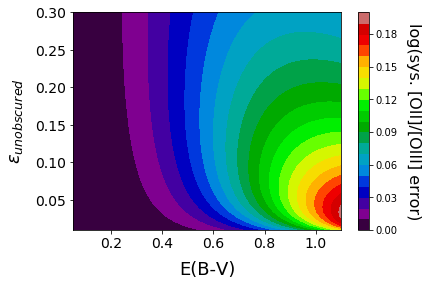

In [9]:
x = np.linspace(0.05, 1.1, 50)
y = np.linspace(0.01, 0.3, 50)

X, Y = np.meshgrid(x, y)
Z = sys_err_array_orig(0.3727,0.5007,X,Y)  # this is specific to 3727 / 5007

#plt.contourf(X, Y, Z, 20, cmap='RdGy');
#plt.contourf(X, Y, Z, 20, cmap='nipy_spectral'); #orig
plt.contourf(X, Y, Z, 20, cmap='nipy_spectral',vmin=0,vmax=0.2); #KK
#plt.colorbar();
plt.xlabel('E(B-V)',fontsize=18,labelpad=10)
plt.tick_params(labelsize=14)
plt.ylabel('$\epsilon_{unobscured}$',fontsize=18,labelpad=10)
plt.clim([0,.2])#KK
cbar = plt.colorbar()
cbar.set_label('log(sys. [OII]/[OIII] error)', rotation=270,fontsize=16,labelpad=23)
plt.savefig('systematic_dereddening_error_orig.pdf')

Now assume there is a certain foreground absorption of E(B-V), that covers all but $\epsilon$ of the spaxel (where the flux emerges unattenuated).
Let's make a 2D plot of the systematic error incurred when using the Balmer decrement to de-reddene [SII]/[SIII], as a function of E(B-V) and $\epsilon$

            This has been deprecated in v4.0 and support will be removed in v4.1.
            Starting with v4.0 classes must define a class attribute ``n_inputs``.
            Please consult the documentation for details.
             [astropy.modeling.core]


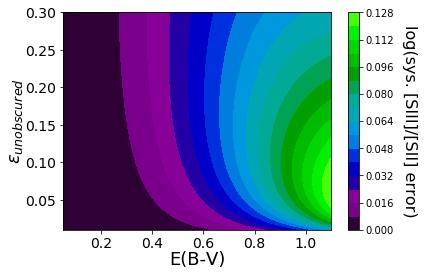

In [39]:
x = np.linspace(0.05, 1.1, 50)
y = np.linspace(0.01, 0.3, 50)

X, Y = np.meshgrid(x, y)
Z = sys_err_array(0.9069,0.6716,X,Y)  # this is specific to 3727 / 5007

#plt.contourf(X, Y, Z, 20, cmap='RdGy');
#plt.contourf(X, Y, Z, 20, cmap='nipy_spectral'); #orig
plt.contourf(X, Y, Z, 20, cmap='nipy_spectral',vmin=0,vmax=0.2); #KK
#plt.colorbar();
plt.xlabel('E(B-V)',fontsize=18,labelpad=0)
plt.tick_params(labelsize=14)
plt.ylabel('$\epsilon_{unobscured}$',fontsize=18,labelpad=0)
cbar = plt.colorbar()
cbar.set_label('log(sys. [SIII]/[SII] error)', rotation=270,fontsize=16,labelpad=23)
plt.savefig('systematic_dereddening_error_F99_Sulphur.pdf')

In [41]:
tmparr=Z[:,26]
np.median(tmparr)

0.03821199487020278